<a href="https://colab.research.google.com/github/Muzsek/A.I.-Projects/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = Path('/content/drive/MyDrive/Colab/archive.zip')
data = Path('data')

In [ ]:
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data)

In [ ]:
training_path = Path('data/Training')
testing_path = Path('data/Testing')

In [ ]:
os.listdir(training_path)

['notumor', 'meningioma', 'glioma', 'pituitary']

In [ ]:
os.listdir(Path(f'{training_path}/meningioma'))[:5]

['Tr-me_0862.jpg',
 'Tr-me_1325.jpg',
 'Tr-me_1083.jpg',
 'Tr-me_0488.jpg',
 'Tr-me_0867.jpg']

In [ ]:
meningioma_images = list(os.listdir(Path(f'{training_path}/meningioma')))

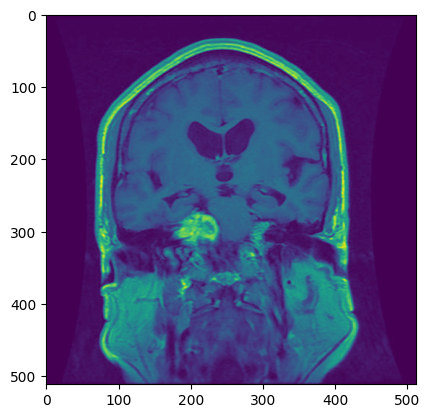

In [ ]:
sample_image = plt.imread(Path(f'{training_path}/meningioma/{meningioma_images[0]}'))
plt.imshow(sample_image)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
training_dataset = torchvision.datasets.ImageFolder(root=training_path, transform=transform)
testing_dataset = torchvision.datasets.ImageFolder(root = testing_path, transform = transform)

In [ ]:
print(f"Training data shape: {training_dataset[0][0].shape}")
print(f"Testing data shape: {testing_dataset[0][0].shape}")

Training data shape: torch.Size([3, 128, 128])
Testing data shape: torch.Size([3, 128, 128])


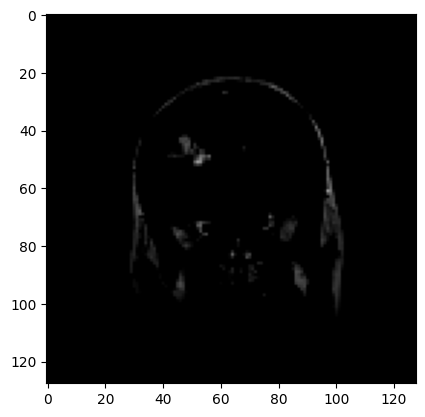

In [ ]:

plt.imshow(training_dataset[0][0].permute(1, 2, 0))

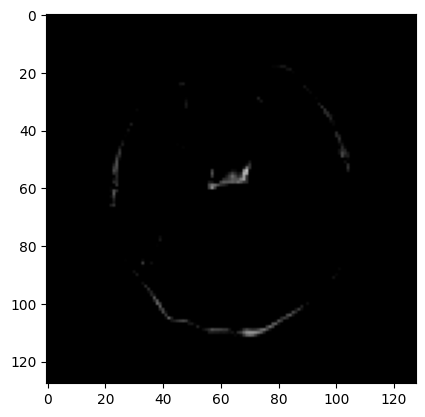

In [ ]:
plt.imshow(testing_dataset[0][0].permute(1,2,0))

In [ ]:
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)

In [ ]:

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features =  128 * 16 * 16, out_features = 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 256, out_features = 4)
        )

    def forward(self, x):
      x = self.conv_block1(x)
      # print(x.shape)
      x = self.conv_block2(x)
      # print(x.shape)
      x = self.conv_block3(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x

model_0 = CNN().to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model_0.parameters(), lr = 1e-3)

In [ ]:
epochs = 10
train_loss = 0
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n----------")
    for batch, (X, y) in enumerate(training_loader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(training_loader.dataset)} samples")
          print(f"Loss: {loss}")

        train_loss /= len(training_loader)

        test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in testing_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(testing_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(testing_loader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n Accuracy:{test_acc:.2f}")

Epoch: 0
----------
Looked at 0/5712 samples
Loss: 1.390105128288269

Train loss: 0.00211 | Test loss: 0.51340, Test acc: 78.35%
 Accuracy:78.35
Epoch: 1
----------
Looked at 0/5712 samples
Loss: 0.39954137802124023

Train loss: 0.00120 | Test loss: 0.48544, Test acc: 80.11%
 Accuracy:80.11
Epoch: 2
----------
Looked at 0/5712 samples
Loss: 0.20194707810878754

Train loss: 0.00144 | Test loss: 0.28126, Test acc: 88.34%
 Accuracy:88.34
Epoch: 3
----------
Looked at 0/5712 samples
Loss: 0.18308672308921814

Train loss: 0.00026 | Test loss: 0.20634, Test acc: 91.84%
 Accuracy:91.84
Epoch: 4
----------
Looked at 0/5712 samples
Loss: 0.09535343945026398

Train loss: 0.00129 | Test loss: 0.15633, Test acc: 94.05%
 Accuracy:94.05
Epoch: 5
----------
Looked at 0/5712 samples
Loss: 0.08124330639839172

Train loss: 0.00163 | Test loss: 0.12680, Test acc: 95.50%
 Accuracy:95.50
Epoch: 6
----------
Looked at 0/5712 samples
Loss: 0.11520785838365555

Train loss: 0.00064 | Test loss: 0.11566, Test a